# NN Train on MNIST digits

In [14]:
import math
import random
import numpy as np
import time
import keras
from tqdm import trange
from IPython.display import clear_output

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [15]:
IMAGE_SIZE_X = 28
IMAGE_SIZE_Y = 28
IMAGE_SIZE = IMAGE_SIZE_X * IMAGE_SIZE_Y
LABELS_SIZE = 10


In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [17]:
def compute_loss(labels, outputs):
    m = labels.shape[0]
    return -(1/m) * ( np.sum( np.multiply(np.log(outputs),labels)) + 
                      np.sum( np.multiply(np.log(1-outputs),(1-labels))))

# Example simple NN for MNIST digits only using numpy (and keras to load data)
https://towardsdatascience.com/building-an-artificial-neural-network-using-pure-numpy-3fe21acc5815

In [18]:
# Display a 28x28 digit image
def print_digit(digit):
    test_digit = np.mat(digit).reshape(28,28)
    plt.imshow(test_digit, cmap='gray')
    plt.show()

In [19]:
def load_dataset(flatten=False):
    """
    Returns:
    images_train - training data     50000x784
    labels_train - training labels   50000x1
    images_validate   - validation data   10000x784
    labels_validate   - validation labels 10000x1
    images_test  - test data         10000x784
    labels_test  - test labels       10000x1
    
    The source data loaded via keras holds the images as 28x28 - the 'flatten' arg will convert this to 784x1.

    images_mnist is initially 60000x28x28, and images_test is 10000x28x28
    
    The images are 'flattened' to 784x1, and also the pixels are normalized from 0..255 to 0..1

    images_mnist (60000x28x28) is split into images_train (50000x784) and images_validate (10000x784) 
    (similarly labels_train, and labels_validate)
    """
    # Use keras library to load MNIST data from interweb
    (images_mnist, labels_mnist), (images_test, labels_test) = keras.datasets.mnist.load_data()
    print("Loaded training data", images_mnist.shape)
    print("Loaded test data", images_test.shape)

    # normalize input pixel values int 0..255 to float 0..1
    images_mnist = images_mnist.astype(float) / 255.
    images_test = images_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    images_train = images_mnist[:-10000]    # training set all but last 10000
    images_validate = images_mnist[-10000:] # validation set last 100000
    
    labels_train = labels_mnist[:-10000]
    labels_validate = labels_mnist[-10000:]

    if flatten:
        images_train = images_train.reshape([images_train.shape[0], -1])
        images_validate = images_validate.reshape([images_validate.shape[0], -1])
        images_test = images_test.reshape([images_test.shape[0], -1])

    return images_train, labels_train, images_validate, labels_validate, images_test, labels_test

### Display first few images (train, validate, test)

In [20]:
def print_load_data():
    #fig = plt.figure(figsize=[8,8])
    fig, axs = plt.subplots(3,4)
    plt.subplots_adjust(wspace=0.3,hspace=0.6)
    fig.suptitle('Training, Validation and Test images 0..3')
    for i in range(4):
    # create subplot rows,cols,index (index starts at 1)
        axs[0,i].imshow(images_train[i].reshape([28,28]),cmap='gray')
        axs[0,i].set_title("Label: {label}".format(label=labels_train[i]))
        axs[1,i].imshow(images_validate[i].reshape([28,28]),cmap='gray')
        axs[1,i].set_title("Label: {label}".format(label=labels_validate[i]))
        axs[2,i].imshow(images_test[i].reshape([28,28]),cmap='gray')
        axs[2,i].set_title("Label: {label}".format(label=labels_test[i]))

## NN Definition Functions

In [21]:
class Layer:
    """
    General Layer parent class, extended by Dense, ReLu
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        self.weights = np.zeros(shape=(input.shape[1], 10))
        bias = np.zeros(shape=(10,))
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, 10]
        """
        output = np.matmul(input, self.weights) + bias
        return output

In [22]:
class Dense(Layer):
    # has properties:
    # .learning_rate (number)
    # .weights
    # .biases
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return np.matmul(input, self.weights) + self.biases
      
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output,np.transpose(self.weights))

        # compute gradient w.r.t. weights and biases
        grad_weights = np.transpose(np.dot(np.transpose(grad_output),input))
        grad_biases = np.sum(grad_output, axis = 0)
        
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        return grad_input

In [23]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(0,input)

    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad 

In [24]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

In [25]:
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]
  

In [26]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    for i in range(len(network)):
        activations.append(network[i].forward(X))
        X = network[i].forward(X)
        
    assert len(activations) == len(network)
    return activations

In [27]:
def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

In [28]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    for i in range(1, len(network)):
        loss_grad = network[len(network) - i].backward(layer_activations[len(network) - i - 1], loss_grad)
    
    return np.mean(loss)
  

In [29]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        

In [37]:
images_train, labels_train, images_validate, labels_validate, images_test, labels_test = load_dataset(flatten=True)

Loaded training data (60000, 28, 28)
Loaded test data (60000, 28, 28)


In [35]:
def print_load_data():
    print("training images:{} labels:{}, validation images:{} labels:{}, test images:{} labels:{}"
      .format(images_train.shape, labels_train.shape, images_validate.shape, labels_validate.shape, images_test.shape, labels_test.shape))
    
    fig, axs = plt.subplots(3,4, figsize=(10,10))
    plt.subplots_adjust(wspace=0.3,hspace=0.6)
    fig.suptitle('Training, Validation and Test images 0..3')
    for i in range(4):
    # create subplot rows,cols,index (index starts at 1)
        axs[0,i].imshow(images_train[i].reshape([28,28]),cmap='gray',aspect='auto')
        axs[0,i].set_title("Label: {label}".format(label=labels_train[i]))
        axs[1,i].imshow(images_validate[i].reshape([28,28]),cmap='gray', aspect='auto')
        axs[1,i].set_title("Label: {label}".format(label=labels_validate[i]))
        axs[2,i].imshow(images_test[i].reshape([28,28]),cmap='gray', aspect='auto')
        axs[2,i].set_title("Label: {label}".format(label=labels_test[i]))

training images:(50000, 784) labels:(50000,), validation images:(10000, 784) labels:(10000,), test images:(10000, 784) labels:(10000,)


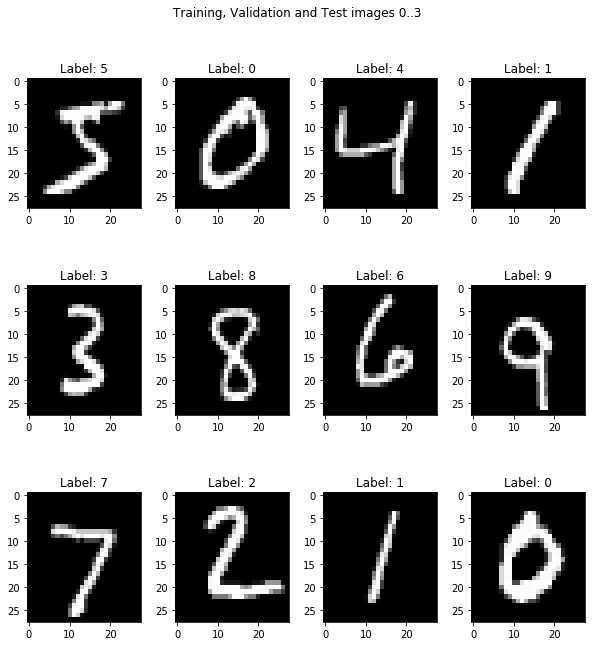

In [36]:
print_load_data()

## Create Neural Network from Layers

In [33]:
network = []
network.append(Dense(images_train.shape[1],100))
network.append(ReLU())
#network.append(Dense(100,10))
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

## Train the network

Epoch 25
Train accuracy: 0.90556
Val accuracy: 0.9115


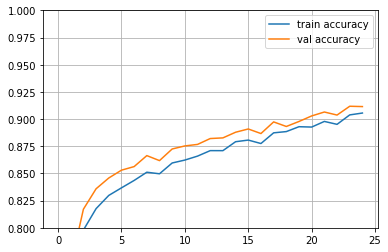

In [34]:
epochs = 25
train_log = []
val_log = []
for epoch in range(epochs):

    for x_batch,y_batch in iterate_minibatches(images_train,labels_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,images_train)==labels_train))
    
    val_log.append(np.mean(predict(network,images_validate)==labels_validate))
    
    clear_output()
    print("Epoch",epoch+1)
    print("Train accuracy:",train_log[-1])
    print("Validation accuracy:",val_log[-1])
    plt.plot(train_log,label='train images')
    plt.plot(val_log,label='validation images')
    plt.yscale('linear')
    plt.gca().set_ylim([0.8,1.0])
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Test an image

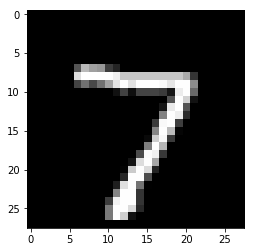

In [151]:
print_digit(images_test[0])

## Draw accuracy / time plot

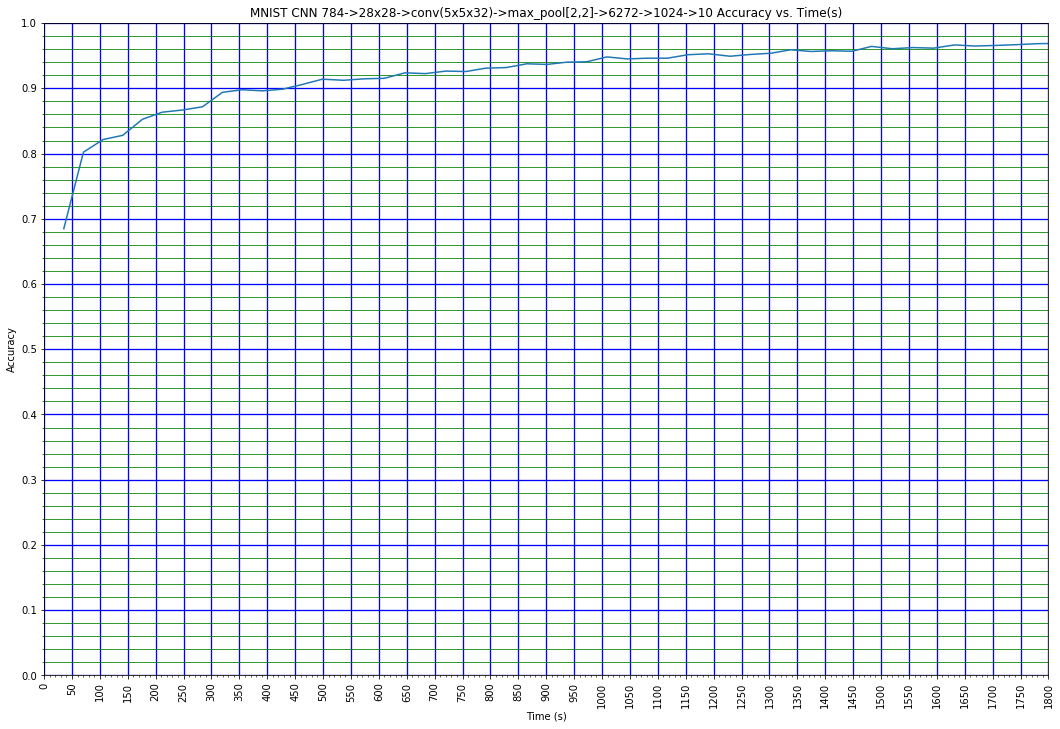

In [45]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1, 1, 1)

ax.set_title("MNIST CNN 784->28x28->conv(5x5x32)->max_pool[2,2]->6272->1024->10 Accuracy vs. Time(s)", fontsize='large')

## Set up Time x axis

ax.set_xlabel("Time (s)")
# Min x axis value is 0 (so y-axis crosses at x=0)
ax.set_xlim(left=0)
# x ticks at 10s
ax.set_xticks(np.arange(0.0,max(graph_data_time),STEPS_COUNT))
ax.xaxis.grid(which='major', color='b', linewidth=1.3)

## Set up Accuracy y axis

ax.set_ylabel("Accuracy")
ax.set_ylim(bottom=0)
# Set Accuracy tick locations and define horizontal grid lines
minorLocator = MultipleLocator(0.05)
majorLocator = MultipleLocator(0.1)
ax.yaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.grid(which='major', color='b', linewidth=1.3)
ax.yaxis.grid(which='minor', color='g')

# Plot the chart
ax.plot(graph_data_time, graph_data_accuracy)

plt.minorticks_on()
plt.xticks(rotation=90)
plt.show(fig)